In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../Datasets/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels_names = np.argmax(train_labels, axis=1)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)
test_labels_names = np.argmax(test_labels, axis=1)

print("train_data: ", train_data.shape)
print("train_labels: ", train_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", test_labels.shape)

train_data:  (55000, 784)
train_labels:  (55000, 10)
test_data:  (10000, 784)
test_labels:  (10000, 10)


In [4]:
num_of_examples = 5000

train_labels_names_dict = {}

for example_i, example_label in enumerate(train_labels_names[:num_of_examples]):
    train_labels_names_dict.setdefault(example_label, [])
    train_labels_names_dict[example_label].append(example_i)

In [5]:
num_of_domains = 2
num_of_features = [784, 784]
domain_names = ["domain_0", "domain_1"]

# num_of_domains = 3
# num_of_features = [784, 784, 784]
# domain_names = ["domain_0", "domain_1", "domain_2"]

# num_of_domains = 3
# num_of_features = [10, 20, 30]
# domain_names = ["domain_0", "domain_1", "domain_2"]

In [6]:
HIDDEN_LAYER_UNITS = [512, 384, 256]
ACTIVATION_FUNCTION = tf.nn.elu
CODE_VECTOR = 10
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 1000

In [7]:
def encoder(X, domain_name):
    for i in range(1, len(HIDDEN_LAYER_UNITS)+1):
        if i == 1:
            net = tf.layers.dense(inputs=X, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Encoder_"+domain_name+"_layer_"+str(i))
            #print(net)
        else:
            net = tf.layers.dense(inputs=net, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Encoder_"+domain_name+"_layer_"+str(i))
            #print(net)
    return net

def latent_code(X):
    _, encoder_len = X.get_shape()
    z_mu = tf.layers.dense(inputs=X, units=encoder_len, activation=None, name='z_mu')
    z_log_sigma_sq = tf.layers.dense(inputs=X, units=encoder_len, activation=None, name='z_log_sigma_sq')
    eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
    z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps # The reparameterization trick
    
    return z, z_mu, z_log_sigma_sq

def decoder(net, domain_size, domain_name):
    for i in range(len(HIDDEN_LAYER_UNITS), 0, -1):
        net = tf.layers.dense(inputs=net, units=HIDDEN_LAYER_UNITS[i-1], activation=ACTIVATION_FUNCTION, name="Decoder_"+domain_name+"_layer_"+str(i))
        #print(net)
    net = tf.layers.dense(inputs=net, units=domain_size, activation=tf.sigmoid, name="Decoder_Final_"+domain_name) # For MNIST, pixels are between 0 & 1
    #print(net)
    return net

def loss(true_output, prediction, latent_loss):
    
    # Reconstruction cost
    recon_loss = -tf.reduce_sum(true_output * tf.log(1e-10+prediction) + (1-true_output) * tf.log(1e-10+1-prediction), axis=1)
    cost = tf.reduce_mean(recon_loss)
    
    cost = tf.reduce_mean(cost + latent_loss)
    
    return cost

In [8]:
placeholder = {"input":[], "output":[], "prediction": []}

for a_domain in range(num_of_domains):
    placeholder["input"].append(tf.placeholder("float", [None, num_of_features[a_domain]], name='input_'+str(a_domain)))
    placeholder["output"].append(tf.placeholder("float", [None, num_of_features[a_domain]], name='output_'+str(a_domain)))

#encoder_outputs = tf.placeholder("float", [None, None])
encoder_outputs = encoder(placeholder["input"][0], domain_names[0])
for a_domain in range(1, num_of_domains):
    a_encoder_output = encoder(placeholder["input"][a_domain], domain_names[a_domain])
    encoder_outputs= tf.concat([encoder_outputs, a_encoder_output], axis=1, name='encoder_outputs')
print("encoder_outputs: ", encoder_outputs)

code_prediction, z_mu, z_log_sigma_sq = latent_code(encoder_outputs)
print("code_prediction: ", code_prediction)

for a_domain in range(num_of_domains):
    a_decoder_output = decoder(code_prediction, num_of_features[a_domain], domain_names[a_domain])
    placeholder["prediction"].append(a_decoder_output)
print("prediction: ", placeholder["prediction"])

# Reconstruction cost
# concatenating all the domains to optimize them together  
# prediction_concat = tf.placeholder("float", [None, None])
# output_concat = tf.placeholder("float", [None, None])
prediction_concat = placeholder["prediction"][0]
output_concat = placeholder["output"][0]
for a_domain in range(1, num_of_domains):
    prediction_concat= tf.concat([prediction_concat, placeholder["prediction"][a_domain]], axis=1, name='prediction_concat')
    output_concat= tf.concat([output_concat, placeholder["output"][a_domain]], axis=1, name='output_concat')
print("prediction_concat", prediction_concat)
print("output_concat", output_concat)

recon_loss = -tf.reduce_sum(output_concat * tf.log(1e-10+prediction_concat) + (1-output_concat) * tf.log(1e-10+1-prediction_concat), axis=1)
cost = tf.reduce_mean(recon_loss)

# Latent loss
# Kullback Leibler divergence: measure the difference between two distributions
# Here we measure the divergence between the latent distribution and N(0, 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
latent_loss = tf.reduce_mean(latent_loss)

cost = tf.reduce_mean(cost + latent_loss)
print("cost: ", cost)

train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cost)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initializing the variables
sess = tf.Session()  # tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


encoder_outputs:  Tensor("encoder_outputs:0", shape=(?, 512), dtype=float32)
code_prediction:  Tensor("add:0", shape=(?, 512), dtype=float32)
prediction:  [<tf.Tensor 'Decoder_Final_domain_0/Sigmoid:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'Decoder_Final_domain_1/Sigmoid:0' shape=(?, 784) dtype=float32>]
prediction_concat Tensor("prediction_concat:0", shape=(?, 1568), dtype=float32)
output_concat Tensor("output_concat:0", shape=(?, 1568), dtype=float32)
cost:  Tensor("Mean_2:0", shape=(), dtype=float32)


In [9]:
domains_data = {}

for a_domain in range(num_of_domains):
    x_data = []
    for a_label in sorted(train_labels_names_dict.keys()):
        #print(a_label)
        example_i_list = train_labels_names_dict[a_label]
        np.random.shuffle(example_i_list)

        x_data.extend(train_data[example_i_list])
    
    domains_data['domain_'+str(a_domain)] = np.array(x_data)

In [10]:
feed_dict = {}
for a_domain in range(num_of_domains):
    #print(a_domain)
    feed_dict[placeholder["input"][a_domain]] = domains_data['domain_'+str(a_domain)]
    feed_dict[placeholder["output"][a_domain]] = domains_data['domain_'+str(a_domain)]

Epoch: 0100 cost = 428.309844971


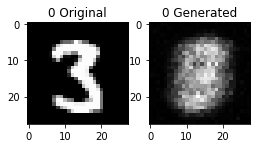

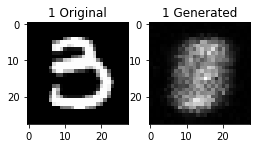

Epoch: 0200 cost = 391.536346436


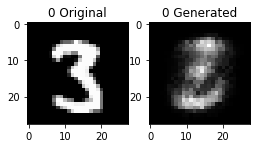

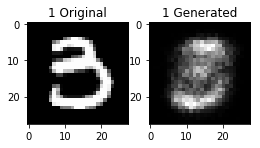

Epoch: 0300 cost = 358.424133301


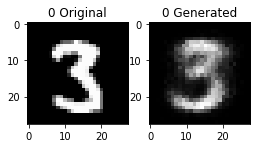

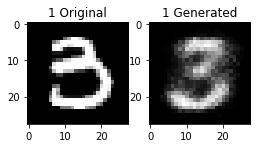

Epoch: 0400 cost = 335.372314453


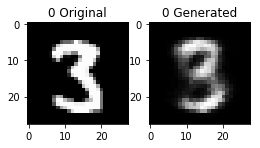

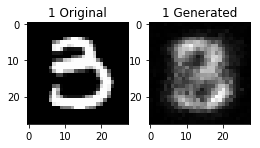

Epoch: 0500 cost = 319.701171875


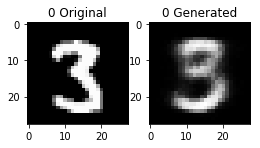

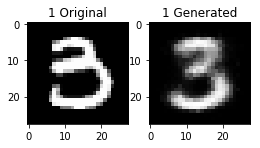

Epoch: 0600 cost = 307.773437500


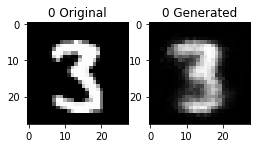

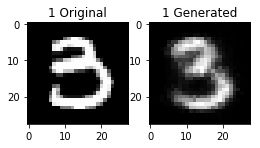

Epoch: 0700 cost = 300.004425049


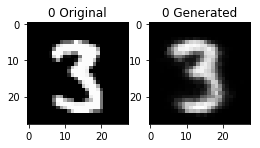

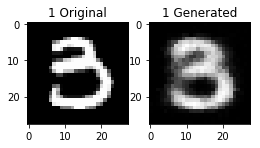

Epoch: 0800 cost = 293.894775391


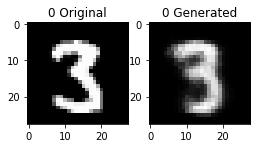

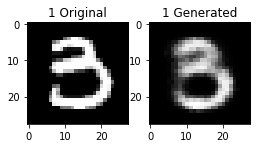

Epoch: 0900 cost = 289.275482178


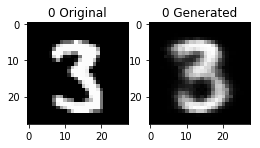

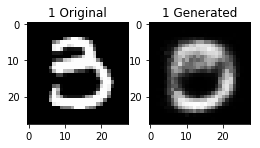

Epoch: 1000 cost = 284.377685547


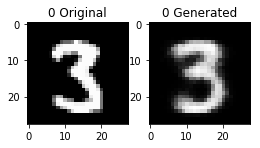

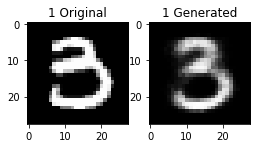

In [11]:
# Write logs to Tensorboard
summary_writer = tf.summary.FileWriter("logs_path", graph=tf.get_default_graph())
            
cost_log = []
# Start Training
for epoch in range(TRAINING_EPOCHS):
    # Run optimization op (backprop), cost op (to get loss value)
    _, c = sess.run([train_op, cost], feed_dict=feed_dict)

    cost_log.append(c)
    
    

#     # Print generated data after every 100 epoch
#     if (epoch + 1) % 100 == 0:
#         d = 0 # domain
#         example = 1000
#         print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(c))
#         #generated_output = sess.run(placeholder["prediction"][d], feed_dict={placeholder["input"][d]: domains_data['domain_'+str(d)]})
#         generated_output = sess.run(placeholder["prediction"][d], feed_dict=feed_dict)
        
#         #print("Original Images")
#         #print(domains_data['domain_'+str(d)][0])
#         canvas_orig = domains_data['domain_'+str(d)][example].reshape([28, 28])
#         #plt.figure(figsize=(n, n))
#         plt.title("Original Images")
#         plt.imshow(canvas_orig, origin="upper", cmap="gray")
#         plt.show()
        
#         #print("Generated Images")
#         #print(list(generated_output[0]))
#         canvas_orig = generated_output[example].reshape([28, 28])
#         #plt.figure(figsize=(n, n))
#         plt.title("Generated Image")
#         plt.imshow(canvas_orig, origin="upper", cmap="gray")
#         plt.show()

    # Print generated data after every 100 epoch
    if (epoch + 1) % 100 == 0:
        example = 2000
        print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(c))
        
        for a_domain in range(num_of_domains):
            #print("a_domain: ", a_domain)
            #all_plots = plt.figure(figsize=(1, 1))
            fig, all_plots = plt.subplots(1, 2, figsize=(4, 4))
            generated_output = sess.run(placeholder["prediction"], feed_dict=feed_dict)

            canvas_orig = domains_data['domain_'+str(a_domain)][example].reshape([28, 28])
            #plt.figure(figsize=(n, n))
            all_plots[0].set_title(str(a_domain)+" Original")
            all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

            #print("Generated Images")
            #print(list(generated_output[0]))
            canvas_orig = generated_output[a_domain][example].reshape([28, 28])
            #plt.figure(figsize=(n, n))
            all_plots[1].set_title(str(a_domain)+" Generated")
            all_plots[1].imshow(canvas_orig, origin="upper", cmap="gray")
        
        plt.show()

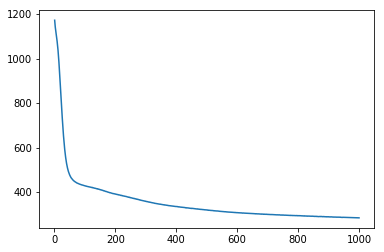

In [12]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

Text(-150, -300, 'Seconds')

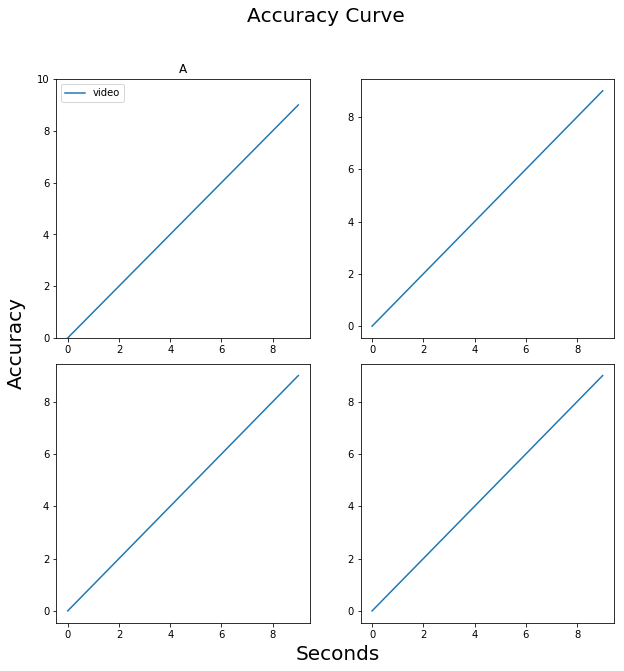

Original Images


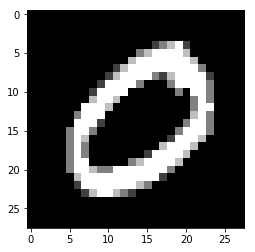

In [14]:
canvas_orig= train_data[115].reshape([28, 28])

print("Original Images")     
#plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

In [15]:
not(True)

False